In [1]:
import os
os.chdir('../pipeline/src/')

In [2]:
from diag_tcn_vae import DiagTcnVAE

Global seed set to 42


In [3]:
model = DiagTcnVAE.load_from_checkpoint("../../data/tmp/trained_model")

/home/jovyan/diag-tcn-vae/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.5, which is newer than your current Lightning version: v2.0.0
  rank_zero_warn(


In [4]:
from tep_data_module import TEPDataModule, TEPDataset

In [5]:
import pandas as pd
import joblib
import constants as const
import torch
import numpy as np
import matplotlib.pyplot as plt


In [6]:
scaler = joblib.load("../../data/tmp/scaler")
df_train = pd.read_parquet("../../data/tmp/df_train.parquet")
df_val = pd.read_parquet("../../data/tmp/df_val.parquet")
df_test = pd.read_parquet("../../data/tmp/df_test.parquet")


/home/jovyan/diag-tcn-vae/.venv/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [16]:
df_sc = pd.DataFrame(scaler.transform(df_test.values), columns=df_test.columns)
df_sc = pd.DataFrame(scaler.transform(df_val.values), columns=df_val.columns)
df_sc = pd.DataFrame(scaler.transform(df_train.values), columns=df_val.columns)

In [17]:
ds = TEPDataset(
    dataframe=df_sc,
    input_cols=const.DATA_COLS,
    subsystems_map=const.SUBSYSTEM_MAP,
)

In [37]:
y_ls = []
scores_ls = []
reconstructions_ls = []
for i in range(10):
    x, x_comp_ls, y = ds[i]
    with torch.no_grad():
        scores, z, x_hat_ls = model.predict(torch.Tensor(x), [torch.Tensor(x).reshape(1, *x.shape) for x in x_comp_ls])    
    scores = torch.cat(scores)
    reconstructions_ls.append(x_hat_ls)
    scores_ls.append(np.array(scores).reshape(-1))
    y_ls.append(y[0])

In [38]:
z

tensor([[-13.1756, 143.1186,  77.6424, -50.1998, -70.6585]])

In [19]:
recon_ls = [torch.cat([recon[i].reshape(*recon[i].shape[1:]) for i in range(len(const.SUBSYSTEM_MAP.keys()))]).numpy() for recon in reconstructions_ls]


In [20]:
recon_ls[2].shape

(41, 480)

In [21]:
cols = []
for liste in [const.SUBSYSTEM_MAP[k] for k in sorted(const.SUBSYSTEM_MAP.keys())]:
    cols.extend(liste)

In [22]:
type(ds[0][0])

numpy.ndarray

In [23]:
type(recon_ls[0])

numpy.ndarray

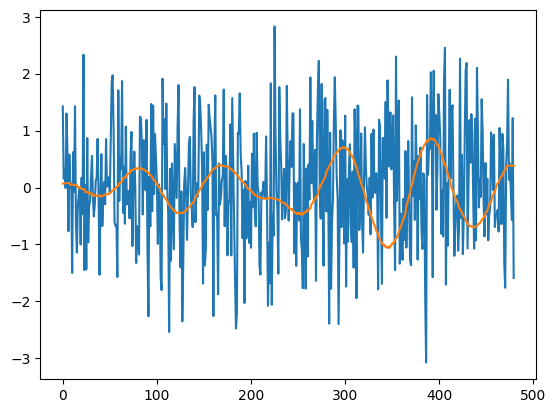

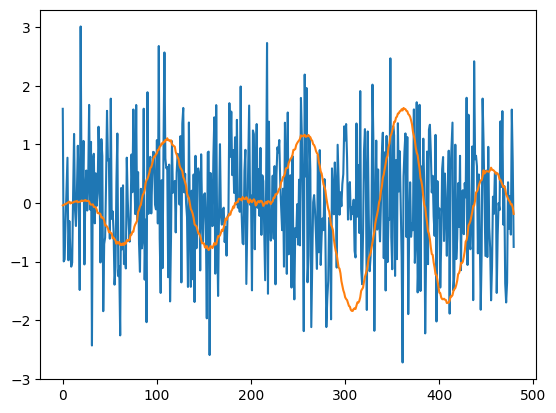

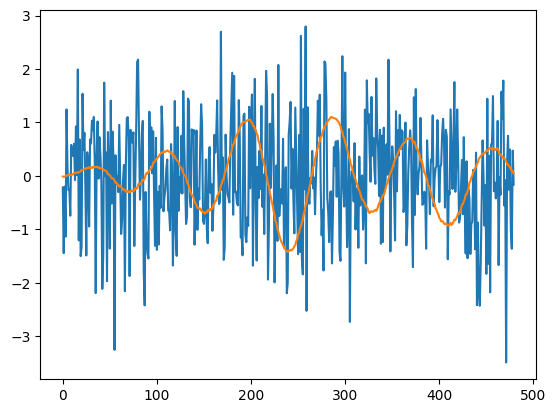

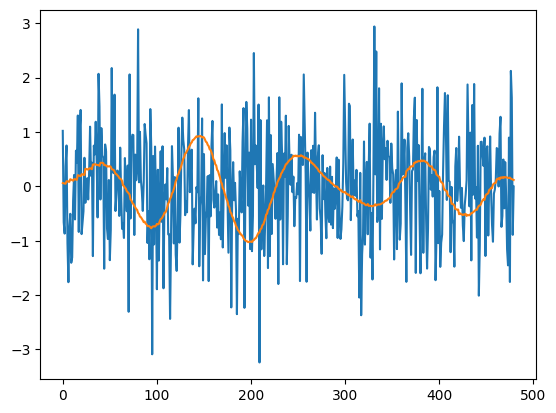

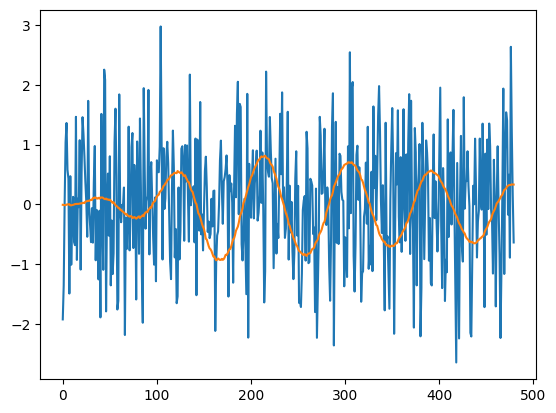

In [36]:
for sample in range(5):
    SAMPLE = 5
    SIGNAL = 11
    fig = plt.figure()
    plt.plot(ds[sample][0][SIGNAL, :])
    plt.plot(recon_ls[sample][SIGNAL, :])

In [34]:
results_df = pd.DataFrame(scores_ls, columns=sorted(const.SUBSYSTEM_MAP.keys()))
results_df['faultNumber'] = y_ls

In [11]:
results_df.head()

,Unnamed: 0,Compressor,InputFeed,Product,ProductSeparator,Purge,PurgeGas,Reactor,ReactorFeed,Stripper,faultNumber
0,0,17.454214,66.527170,3.431024,5.923063,5.695470,6.974011,5.014601,4.978922,25.568228,1.0
1,1,1.363285,6.135337,2.820558,14.299952,794.082600,96.042656,2.886031,76.465320,22.327154,2.0
2,2,0.307153,0.856480,0.898892,0.874990,0.810745,0.739750,0.847407,0.830685,0.684693,3.0
3,3,0.302754,0.858818,0.895720,0.886847,0.803931,0.737507,0.842187,0.828796,0.660993,4.0
4,4,5.348684,1.659600,1.849745,2.948717,1.455716,2.077691,1.834844,1.854293,2.684343,5.0


In [36]:
results_df.to_csv('../../data/tmp/results.csv')

In [6]:
results_df = pd.read_csv('../../data/tmp/results.csv')

In [17]:
results_df

,Unnamed: 0,Compressor,InputFeed,Product,ProductSeparator,Purge,PurgeGas,Reactor,ReactorFeed,Stripper,faultNumber
0,0,17.454214,66.527170,3.431024,5.923063,5.695470,6.974011,5.014601,4.978922,25.568228,1.0
1,1,1.363285,6.135337,2.820558,14.299952,794.082600,96.042656,2.886031,76.465320,22.327154,2.0
2,2,0.307153,0.856480,0.898892,0.874990,0.810745,0.739750,0.847407,0.830685,0.684693,3.0
3,3,0.302754,0.858818,0.895720,0.886847,0.803931,0.737507,0.842187,0.828796,0.660993,4.0
4,4,5.348684,1.659600,1.849745,2.948717,1.455716,2.077691,1.834844,1.854293,2.684343,5.0
...,...,...,...,...,...,...,...,...,...,...,...
995,995,2.196660,1.043448,1.141693,1.241320,0.897867,1.143366,1.201084,0.960268,2.121684,16.0
996,996,1.783865,1.102931,1.011594,1.834024,1.227084,1.387286,320.141630,1.029636,1.649251,17.0
997,997,445.381500,72.072440,55.053080,282.794500,12.052200,99.287380,226.207640,85.406800,203.758990,18.0
998,998,1.396957,1.889373,0.920299,1.004036,0.825508,0.942693,1.281669,0.887245,0.800354,19.0


In [27]:
import plotly.express as px

for col in sorted(const.SUBSYSTEM_MAP.keys()):
    fig = px.box(results_df, x='faultNumber', y=col, title=f'Boxplot of {col} grouped by faultNumber')
    fig.show()

In [40]:
import pandas as pd
import plotly.subplots as sp
import plotly.graph_objects as go

# read data
# result_df = pd.read_parquet(df_test_results.path)

# Create subplots: nrows is the number of keys in subsystems_map
fig = sp.make_subplots(rows=len(const.SUBSYSTEM_MAP.keys()), cols=1)

for idx, col in enumerate(sorted(const.SUBSYSTEM_MAP.keys())):
    fig.add_trace(
        go.Box(x=results_df["faultNumber"], y=results_df[col], name=col),
        row=idx+1,
        col=1
    )
    fig.update_xaxes(title_text="faultNumber", row=idx+1, col=1)
    fig.update_yaxes(title_text=col, row=idx+1, col=1)

fig.update_traces(boxpoints='all', jitter=.5)
fig.update_layout(height=400*len(const.SUBSYSTEM_MAP.keys()), title_text="Boxplots grouped by faultNumber")
fig.show()

In [13]:
import torch

In [14]:
mu_z, log_var_z = model.encode(torch.Tensor(x))

In [15]:
z = model.sample_gaussian(mu_z, log_var_z)

In [20]:
x_comp_ls[5].shape

(8, 480)

In [19]:
model.decode(z)[5].shape

torch.Size([1, 8, 480])

In [18]:
model.component_output_dims

[1, 5, 5, 5, 1, 8, 5, 6, 5]

In [22]:
[len(const.SUBSYSTEM_MAP[k]) for k in sorted(const.SUBSYSTEM_MAP.keys())]

[1, 5, 5, 5, 1, 8, 5, 6, 5]

In [22]:
{sorted(const.SUBSYSTEM_MAP.keys())

['Compressor',
 'InputFeed',
 'Product',
 'ProductSeparator',
 'Purge',
 'PurgeGas',
 'Reactor',
 'ReactorFeed',
 'Stripper']

In [23]:
%%time 
model.predict(torch.Tensor(x), [torch.Tensor(x).reshape(1, *x.shape) for x in x_comp_ls])

torch.Size([1, 1, 480])
CPU times: user 3.06 s, sys: 0 ns, total: 3.06 s
Wall time: 51.2 ms


([tensor([17.4491], grad_fn=<MeanBackward1>),
  tensor([66.5308], grad_fn=<MeanBackward1>),
  tensor([3.4294], grad_fn=<MeanBackward1>),
  tensor([5.9373], grad_fn=<MeanBackward1>),
  tensor([5.6894], grad_fn=<MeanBackward1>),
  tensor([6.9782], grad_fn=<MeanBackward1>),
  tensor([5.0330], grad_fn=<MeanBackward1>),
  tensor([4.9873], grad_fn=<MeanBackward1>),
  tensor([25.5360], grad_fn=<MeanBackward1>)],
 tensor([[-18.9658,  -2.3695, -36.0991,  38.1788, -82.4833,  81.8217,  92.2794,
          -78.4018, 119.2232, -74.7595]], grad_fn=<AddBackward0>),
 [tensor([[[-3.9130e-01, -3.6752e-01, -2.7567e-01, -2.2922e-01, -1.8006e-01,
            -1.9283e-01, -1.4790e-01, -8.1330e-02,  5.6307e-02,  1.0110e-01,
             1.6839e-01,  1.9717e-01,  2.3983e-01,  2.6629e-01,  2.9267e-01,
             3.1205e-01,  4.5703e-01,  4.8185e-01,  5.1316e-01,  5.2611e-01,
             6.4993e-01,  6.5477e-01,  6.8617e-01,  7.0263e-01,  7.3867e-01,
             7.4066e-01,  7.5289e-01,  7.8174e-01,  8.1550e

In [27]:
x_comp_ls[0].shape

(5, 480)

In [28]:
const.SUBSYSTEM_MAP

{'InputFeed': ['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5'],
 'Reactor': ['xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_21'],
 'Purge': ['xmeas_10'],
 'ProductSeparator': ['xmeas_11',
  'xmeas_12',
  'xmeas_13',
  'xmeas_14',
  'xmeas_22'],
 'Stripper': ['xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19'],
 'Compressor': ['xmeas_20'],
 'ReactorFeed': ['xmeas_23',
  'xmeas_24',
  'xmeas_25',
  'xmeas_26',
  'xmeas_27',
  'xmeas_28'],
 'PurgeGas': ['xmeas_29',
  'xmeas_30',
  'xmeas_31',
  'xmeas_32',
  'xmeas_33',
  'xmeas_34',
  'xmeas_35',
  'xmeas_36'],
 'Product': ['xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41']}

In [29]:
model.decoder_ls[0]

Decoder(
  (fc_in): Linear(in_features=10, out_features=10, bias=True)
  (upsampler1): Upsample(size=400, mode='nearest')
  (tcn1): TCN(
    (net): Sequential(
      (0): Conv1DResidualBlock(
        (conv1): Conv1d(1, 3, kernel_size=(15,), stride=(1,), padding=same)
        (activattion): ReLU()
        (conv2): Conv1d(3, 3, kernel_size=(15,), stride=(1,), padding=same)
        (residual): Conv1d(1, 3, kernel_size=(1,), stride=(1,))
      )
      (1): Conv1DResidualBlock(
        (conv1): Conv1d(3, 5, kernel_size=(15,), stride=(1,), padding=same, dilation=(2,))
        (activattion): ReLU()
        (conv2): Conv1d(5, 5, kernel_size=(15,), stride=(1,), padding=same, dilation=(2,))
        (residual): Conv1d(3, 5, kernel_size=(1,), stride=(1,))
      )
      (2): Conv1DResidualBlock(
        (conv1): Conv1d(5, 6, kernel_size=(15,), stride=(1,), padding=same, dilation=(4,))
        (activattion): ReLU()
        (conv2): Conv1d(6, 6, kernel_size=(15,), stride=(1,), padding=same, dilation=